In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Carica il dataset
data_path = '../data/PRSA_data_2010.1.1-2014.12.31_Beijing.csv'

df = pd.read_csv(data_path)
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

In [3]:
# Funzione per classificare PM2.5 secondo standard EPA
def classify_pm25_epa(pm25_value):
    """
    Classifica un valore PM2.5 secondo gli standard EPA.
    
    Parameters:
    -----------
    pm25_value : float
        Valore PM2.5 in μg/m³
    
    Returns:
    --------
    str : Categoria EPA
    """
    if pd.isna(pm25_value):
        return np.nan
    elif pm25_value <= 12.0:
        return 'Good'
    elif pm25_value <= 35.4:
        return 'Moderate'
    elif pm25_value <= 55.4:
        return 'Unhealthy for Sensitive Groups'
    elif pm25_value <= 150.4:
        return 'Unhealthy'
    elif pm25_value <= 250.4:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

# Applica classificazione al dataset
df['epa_category'] = df['pm2.5'].apply(classify_pm25_epa)

print(f"\nDistribuzione categorie EPA:")
print(df['epa_category'].value_counts().sort_index())
print(f"\nPercentuali:")
print(df['epa_category'].value_counts(normalize=True).sort_index() * 100)


Distribuzione categorie EPA:
epa_category
Good                               3387
Hazardous                          3053
Moderate                           8733
Unhealthy                         15643
Unhealthy for Sensitive Groups     5003
Very Unhealthy                     5938
Name: count, dtype: int64

Percentuali:
epa_category
Good                               8.111215
Hazardous                          7.311349
Moderate                          20.913859
Unhealthy                         37.461982
Unhealthy for Sensitive Groups    11.981225
Very Unhealthy                    14.220370
Name: proportion, dtype: float64


In [4]:
# Import librerie per deep learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [5]:
# Installa PyTorch se necessario
import subprocess
import sys

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "torchvision", "-q"])
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset

In [6]:
print(f"\nDistribuzione categorie EPA:")
print(df['epa_category'].value_counts())




Distribuzione categorie EPA:
epa_category
Unhealthy                         15643
Moderate                           8733
Very Unhealthy                     5938
Unhealthy for Sensitive Groups     5003
Good                               3387
Hazardous                          3053
Name: count, dtype: int64


In [7]:
def create_cumulative_wind_direction(df):
    """
    Crea una feature che accumula la velocità del vento in una direzione specifica.
    Poiché Iws è già cumulata, calcoliamo l'incremento orario (differenza) 
    e lo sommiamo finché la direzione rimane la stessa.
    Quando la direzione cambia, il contatore si resetta.
    
    Args:
        df: DataFrame con colonne 'cbwd' e 'Iws'
        
    Returns:
        pd.Series: Velocità cumulata del vento per direzione (CWD)
    """
    # Inizializza array per CWD
    cwd = np.zeros(len(df))
    
    # Prima riga: Iws iniziale
    cwd[0] = df['Iws'].iloc[0] if pd.notna(df['Iws'].iloc[0]) else 0
    
    # Itera attraverso le righe
    for i in range(1, len(df)):
        current_dir = df['cbwd'].iloc[i]
        prev_dir = df['cbwd'].iloc[i-1]
        current_iws = df['Iws'].iloc[i]
        prev_iws = df['Iws'].iloc[i-1]
        
        # Calcola incremento orario (differenza di Iws)
        if pd.notna(current_iws) and pd.notna(prev_iws):
            iws_increment = current_iws - prev_iws
        else:
            iws_increment = 0
        
        # Se direzione cambia o è NaN, resetta a incremento corrente
        if pd.isna(current_dir) or pd.isna(prev_dir) or current_dir != prev_dir:
            cwd[i] = iws_increment if iws_increment >= 0 else 0
        else:
            # Stessa direzione: accumula l'incremento
            cwd[i] = cwd[i-1] + (iws_increment if iws_increment >= 0 else 0)
    
    return pd.Series(cwd, index=df.index, name='CWD')

In [8]:
# Feature Engineering: estrazione informazioni temporali
df_clean = df[df['epa_category'] != 'Missing'].copy()
df_clean.drop(columns=['No','pm2.5','year','month','day','hour'], inplace=True)

# Crea feature CWD
df_clean['CWD'] = create_cumulative_wind_direction(df_clean)
df_clean.drop(columns=['cbwd','Iws'], inplace=True)

#df_clean = df_clean.dropna()
print(f"\nShape finale: {df_clean.shape}")
display(df_clean.head())
display(df_clean.tail())


Shape finale: (43824, 7)


,DEWP,TEMP,PRES,Is,Ir,epa_category,CWD
datetime,,,,,,,
2010-01-01 00:00:00,-21,-11.0,1021.0,0,0,NaN,1.79
2010-01-01 01:00:00,-21,-12.0,1020.0,0,0,NaN,4.92
2010-01-01 02:00:00,-21,-11.0,1019.0,0,0,NaN,6.71
2010-01-01 03:00:00,-21,-14.0,1019.0,0,0,NaN,9.84
2010-01-01 04:00:00,-20,-12.0,1018.0,0,0,NaN,12.97


,DEWP,TEMP,PRES,Is,Ir,epa_category,CWD
datetime,,,,,,,
2014-12-31 19:00:00,-23,-2.0,1034.0,0,0,Good,228.39
2014-12-31 20:00:00,-22,-3.0,1034.0,0,0,Good,234.20
2014-12-31 21:00:00,-22,-3.0,1034.0,0,0,Good,239.12
2014-12-31 22:00:00,-22,-4.0,1034.0,0,0,Good,243.14
2014-12-31 23:00:00,-21,-3.0,1034.0,0,0,Good,246.27


In [9]:
# Funzione per identificare sequenze continue senza missing
def find_continuous_sequences(series, min_length=100):
    """
    Identifica sequenze continue di valori non-missing di lunghezza >= min_length.
    
    Parameters:
    -----------
    series : pd.Series
        Serie temporale da analizzare
    min_length : int
        Lunghezza minima della sequenza continua
    
    Returns:
    --------
    list of tuples : [(start_idx, end_idx, length), ...]
        Lista di tuple con indici di inizio, fine e lunghezza di ogni sequenza
    """
    sequences = []
    start_idx = None
    current_length = 0
    
    for idx in range(len(series)):
        if pd.notna(series.iloc[idx]):
            # Valore valido
            if start_idx is None:
                start_idx = idx
                current_length = 1
            else:
                current_length += 1
        else:
            # Missing value - salva sequenza se abbastanza lunga
            if start_idx is not None and current_length >= min_length:
                sequences.append((start_idx, idx - 1, current_length))
            start_idx = None
            current_length = 0
    
    # Controlla l'ultima sequenza
    if start_idx is not None and current_length >= min_length:
        sequences.append((start_idx, len(series) - 1, current_length))
    
    return sequences


# Trova sequenze continue di PM2.5
min_sequence_length = 100
continuous_sequences = find_continuous_sequences(df_clean['epa_category'], min_length=min_sequence_length)

print(f"\n SEQUENZE CONTINUE (≥ {min_sequence_length} valori consecutivi senza missing)\n")
print("=" * 90)
print(f"{'#':<5} {'Inizio':<22} {'Fine':<22} {'Lunghezza':<12} {'% Dataset':<12}")
print("=" * 90)

total_continuous_values = 0
for i, (start_idx, end_idx, length) in enumerate(continuous_sequences, 1):
    start_date = df_clean.index[start_idx]
    end_date = df_clean.index[end_idx]
    pct = length / len(df_clean) * 100
    print(f"{i:<5} {str(start_date):<22} {str(end_date):<22} {length:<12,} {pct:<12.2f}%")
    total_continuous_values += length

print("=" * 90)
print(f"\nStatistiche:")
print(f"   Numero sequenze trovate:     {len(continuous_sequences)}")
print(f"   Totale valori in sequenze:   {total_continuous_values:,}")
print(f"   % dataset utilizzabile:      {total_continuous_values/len(df)*100:.2f}%")
print(f"   Media lunghezza sequenza:    {total_continuous_values/len(continuous_sequences):.0f} valori")
print(f"   Sequenza più lunga:          {max([s[2] for s in continuous_sequences]):,} valori")
print(f"   Sequenza più corta:          {min([s[2] for s in continuous_sequences]):,} valori")

# Estrai dati dalle sequenze continue
def extract_continuous_data(dataframe, sequences):
    """
    Estrae i dati dalle sequenze continue e li concatena.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        DataFrame originale
    sequences : list of tuples
        Lista di sequenze (start_idx, end_idx, length)
    
    Returns:
    --------
    pd.DataFrame : DataFrame con solo le sequenze continue
    list : Lista di tuple (seq_id, start_pos, end_pos) per tracciare le sequenze
    """
    continuous_chunks = []
    sequence_info = []
    current_position = 0
    
    for seq_id, (start_idx, end_idx, length) in enumerate(sequences, 1):
        chunk = dataframe.iloc[start_idx:end_idx+1].copy()
        chunk['sequence_id'] = seq_id  # Traccia da quale sequenza proviene
        continuous_chunks.append(chunk)
        
        # Salva informazioni sulla posizione nel nuovo dataset
        sequence_info.append({
            'seq_id': seq_id,
            'original_start': start_idx,
            'original_end': end_idx,
            'new_start': current_position,
            'new_end': current_position + length - 1,
            'length': length,
            'date_start': dataframe.index[start_idx],
            'date_end': dataframe.index[end_idx]
        })
        current_position += length
    
    # Concatena tutte le sequenze
    continuous_df = pd.concat(continuous_chunks, axis=0)
    
    return continuous_df, sequence_info

# Estrai dati continui
df_continuous, seq_info = extract_continuous_data(df_clean, continuous_sequences)

print("Dataset Continuo Estratto\n")
print("=" * 90)
print(f"Shape dataset originale:    {df_clean.shape}")
print(f"Shape dataset continuo:     {df_continuous.shape}")
print(f"Righe mantenute:            {len(df_continuous):,} ({len(df_continuous)/len(df_clean)*100:.2f}%)")
print("=" * 90)

print(f"\nInformazioni Sequenze nel Dataset Continuo:")
print("=" * 90)
print(f"{'Seq':<5} {'Inizio Originale':<20} {'Fine Originale':<20} {'Pos. Nuovo Dataset':<25} {'Lunghezza':<12}")
print("=" * 90)
for info in seq_info:
    pos_range = f"{info['new_start']} - {info['new_end']}"
    print(f"{info['seq_id']:<5} {str(info['date_start']):<20} {str(info['date_end']):<20} "
          f"{pos_range:<25} {info['length']:<12,}")
print("=" * 90)

# Verifica che non ci siano missing nel dataset continuo
missing_in_continuous = df_continuous['epa_category'].isnull().sum()
print(f"\nVerifica: Missing PM2.5 nel dataset continuo: {missing_in_continuous}")


 SEQUENZE CONTINUE (≥ 100 valori consecutivi senza missing)

#     Inizio                 Fine                   Lunghezza    % Dataset   
1     2010-01-02 00:00:00    2010-01-23 16:00:00    521          1.19        %
2     2010-01-26 12:00:00    2010-02-14 01:00:00    446          1.02        %
3     2010-02-14 03:00:00    2010-03-20 04:00:00    818          1.87        %
4     2010-03-23 00:00:00    2010-03-30 05:00:00    174          0.40        %
5     2010-04-01 13:00:00    2010-05-17 16:00:00    1,108        2.53        %
6     2010-05-17 19:00:00    2010-05-27 18:00:00    240          0.55        %
7     2010-05-28 00:00:00    2010-06-01 15:00:00    112          0.26        %
8     2010-06-09 17:00:00    2010-06-20 07:00:00    255          0.58        %
9     2010-06-23 10:00:00    2010-08-13 19:00:00    1,234        2.82        %
10    2010-08-16 16:00:00    2010-09-11 05:00:00    614          1.40        %
11    2010-09-11 22:00:00    2010-09-19 18:00:00    189          0.43 

In [10]:
df_continuous.head()

,DEWP,TEMP,PRES,Is,Ir,epa_category,CWD,sequence_id
datetime,,,,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,0,0,Unhealthy,0.90,1
2010-01-02 01:00:00,-15,-4.0,1020.0,0,0,Unhealthy,1.79,1
2010-01-02 02:00:00,-11,-5.0,1021.0,0,0,Very Unhealthy,2.68,1
2010-01-02 03:00:00,-7,-5.0,1022.0,1,0,Very Unhealthy,4.47,1
2010-01-02 04:00:00,-7,-5.0,1022.0,2,0,Unhealthy,5.36,1


In [11]:
# Funzione per creare finestre temporali (sliding window)
def create_sequences_from_continuous(data, sequence_info, window_size=24, forecast_horizon=1, 
                                     features=None, target='pm2.5'):
    """
    Crea finestre temporali dalle sequenze continue, rispettando i confini delle sequenze.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame con le sequenze continue
    sequence_info : list of dict
        Informazioni sulle sequenze
    window_size : int
        Dimensione della finestra di input (numero di timesteps passati)
    forecast_horizon : int
        Orizzonte di previsione (numero di timesteps futuri da predire)
    features : list
        Lista di feature da usare (se None, usa tutte tranne target)
    target : str
        Nome della colonna target
    
    Returns:
    --------
    X : np.array
        Array di input shape (n_samples, window_size, n_features)
    y : np.array
        Array di target shape (n_samples, forecast_horizon)
    window_info : list
        Informazioni su ogni finestra (per debugging/analisi)
    """
    if features is None:
        # Usa tutte le feature tranne target e sequence_id
        features = [col for col in data.columns if col not in [target, 'sequence_id']]
    
    X_list = []
    y_list = []
    window_info = []
    
    total_windows = 0
    
    # Processa ogni sequenza separatamente
    for seq in sequence_info:
        seq_id = seq['seq_id']
        start_pos = seq['new_start']
        end_pos = seq['new_end']
        seq_length = seq['length']
        
        # Estrai dati della sequenza
        seq_data = data.iloc[start_pos:end_pos+1]
        
        # Calcola quante finestre possiamo creare da questa sequenza
        max_windows = seq_length - window_size - forecast_horizon + 1
        
        if max_windows <= 0:
            print(f"Sequenza {seq_id} troppo corta ({seq_length}) per creare finestre "
                  f"(necessari almeno {window_size + forecast_horizon})")
            continue
        
        # Crea finestre dalla sequenza
        for i in range(max_windows):
            # Finestra di input
            window_start = i
            window_end = i + window_size
            
            # Valore/i da predire
            target_start = window_end
            target_end = window_end + forecast_horizon
            
            # Estrai dati
            X_window = seq_data[features].iloc[window_start:window_end].values
            y_window = seq_data[target].iloc[target_start:target_end].values
            
            # Verifica che non ci siano NaN (controlla solo se numeric)
            has_nan = False
            try:
                has_nan = np.isnan(X_window).any() or np.isnan(y_window).any()
            except TypeError:
                # Se non è numerico, usa pandas
                has_nan = pd.isna(X_window).any() or pd.isna(y_window).any()
            
            if not has_nan:
                X_list.append(X_window)
                y_list.append(y_window)
                
                window_info.append({
                    'seq_id': seq_id,
                    'window_idx': i,
                    'global_start': start_pos + window_start,
                    'global_end': start_pos + window_end - 1,
                    'target_idx': start_pos + target_start
                })
                
                total_windows += 1
        
        print(f"✓ Sequenza {seq_id}: {max_windows:,} finestre create")
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"\nRiepilogo Windowing:")
    print(f"   Finestre totali create:  {total_windows:,}")
    print(f"   X shape:                 {X.shape} (samples, timesteps, features)")
    print(f"   y shape:                 {y.shape} (samples, forecast_horizon)")
    
    return X, y, window_info
# Parametri windowing
WINDOW_SIZE = 100  # Usa 100 valori precedenti di PM2.5
FORECAST_HORIZON = 1  # Predici il prossimo valore

feature_columns = ['TEMP', 'DEWP', 'PRES', 'Is', 'Ir', 'CWD']  
# Crea finestre temporali
X, y, window_info = create_sequences_from_continuous(
    data=df_continuous,
    sequence_info=seq_info,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    features=feature_columns,  # Solo PM2.5 come input!
    target='epa_category'
)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("=" * 90)
print(f"\nShape finali:")
print(f"   X: {X.shape} → (n_samples={X.shape[0]:,}, timesteps={X.shape[1]}, features={X.shape[2]})")
print(f"   y: {y.shape} → (n_samples={y.shape[0]:,}")

✓ Sequenza 1: 421 finestre create
✓ Sequenza 2: 346 finestre create
✓ Sequenza 2: 346 finestre create
✓ Sequenza 3: 718 finestre create
✓ Sequenza 4: 74 finestre create
✓ Sequenza 3: 718 finestre create
✓ Sequenza 4: 74 finestre create
✓ Sequenza 5: 1,008 finestre create
✓ Sequenza 6: 140 finestre create
✓ Sequenza 7: 12 finestre create
✓ Sequenza 8: 155 finestre create
✓ Sequenza 5: 1,008 finestre create
✓ Sequenza 6: 140 finestre create
✓ Sequenza 7: 12 finestre create
✓ Sequenza 8: 155 finestre create
✓ Sequenza 9: 1,134 finestre create
✓ Sequenza 9: 1,134 finestre create
✓ Sequenza 10: 514 finestre create
✓ Sequenza 11: 89 finestre create
✓ Sequenza 12: 181 finestre create
✓ Sequenza 13: 373 finestre create
✓ Sequenza 14: 352 finestre create
✓ Sequenza 10: 514 finestre create
✓ Sequenza 11: 89 finestre create
✓ Sequenza 12: 181 finestre create
✓ Sequenza 13: 373 finestre create
✓ Sequenza 14: 352 finestre create
✓ Sequenza 15: 847 finestre create
✓ Sequenza 16: 60 finestre create
✓

In [12]:
# Split Train/Test a livello di sequenze intere
# Bilanciato per numero di FINESTRE (non sequenze)

# 1. Conta quante finestre ha ogni sequenza
from collections import defaultdict
windows_per_sequence = defaultdict(int)

for win_info in window_info:
    seq_id = win_info['seq_id']
    windows_per_sequence[seq_id] += 1

total_windows = len(window_info)


# 2. Assegnazione greedy delle sequenze per avvicinarsi al 70/30
target_train_windows = int(0.69 * total_windows)

# Shuffle casuale delle sequenze
np.random.seed(42)
sequence_ids = list(windows_per_sequence.keys())
np.random.shuffle(sequence_ids)

train_sequences = []
test_sequences = []
train_window_count = 0

# Assegna sequenze finché non raggiungi circa il 70%
for seq_id in sequence_ids:
    if train_window_count < target_train_windows:
        train_sequences.append(seq_id)
        train_window_count += windows_per_sequence[seq_id]
    else:
        test_sequences.append(seq_id)

print(f"\nAssegnazione sequenze in train/test:")
print(f"   Train: {len(train_sequences)} sequenze → {sorted(train_sequences)}")
print(f"   Test:  {len(test_sequences)} sequenze → {sorted(test_sequences)}")

# 3. Raccogli indici delle finestre
train_indices = []
test_indices = []

for idx, win_info in enumerate(window_info):
    if win_info['seq_id'] in train_sequences:
        train_indices.append(idx)
    else:
        test_indices.append(idx)

# 4. Estrai i dati
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

print(f"\nPercentuali finestre:")
print(f"   Train: {len(X_train):,} finestre ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test:  {len(X_test):,} finestre ({len(X_test)/len(X)*100:.1f}%)")

# Normalizzazione
from sklearn.preprocessing import StandardScaler
# Reshape per normalizzazione
n_train_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)

n_test_samples = X_test.shape[0]
X_test_reshaped = X_test.reshape(-1, n_features)

# Fit scaler solo sul training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back
X_train_scaled = X_train_scaled.reshape(n_train_samples, n_timesteps, n_features)
X_test_scaled = X_test_scaled.reshape(n_test_samples, n_timesteps, n_features)

print(f"\nNormalizzazione:")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_test_scaled:  {X_test_scaled.shape}")

print(f"\nStatistiche target (PM2.5):")
print(f"   Train - min: {y_train.min():.2f}, max: {y_train.max():.2f}, mean: {y_train.mean():.2f}")
print(f"   Test  - min: {y_test.min():.2f}, max: {y_test.max():.2f}, mean: {y_test.mean():.2f}")


Assegnazione sequenze in train/test:
   Train: 71 sequenze → [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 24, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 60, 63, 64, 66, 67, 68, 69, 70, 71, 72, 74, 75, 77, 78, 79, 80, 81, 83, 85, 86, 87, 92, 93, 95, 96]
   Test:  24 sequenze → [2, 3, 15, 21, 23, 25, 31, 34, 39, 53, 54, 59, 61, 62, 65, 73, 76, 82, 84, 88, 89, 90, 91, 94]

Percentuali finestre:
   Train: 20,010 finestre (69.3%)
   Test:  8,861 finestre (30.7%)

Normalizzazione:
   X_train_scaled: (20010, 100, 6)
   X_test_scaled:  (8861, 100, 6)

Statistiche target (PM2.5):
   Train - min: 0.00, max: 5.00, mean: 2.78
   Test  - min: 0.00, max: 5.00, mean: 2.84

Normalizzazione:
   X_train_scaled: (20010, 100, 6)
   X_test_scaled:  (8861, 100, 6)

Statistiche target (PM2.5):
   Train - min: 0.00, max: 5.00, mean: 2.78
   Test  - min: 0.00, max: 5.00, mean: 2.84


In [13]:
X_train_scaled = np.transpose(X_train_scaled, (0, 2, 1))
X_test_scaled = np.transpose(X_test_scaled, (0, 2, 1))

In [14]:
X_train_scaled.shape, X_test_scaled.shape

((20010, 6, 100), (8861, 6, 100))

# InceptionTime bis

In [ ]:
# Riorganizza dati per PyTorch: da (batch, timesteps, features) a (batch, features, timesteps)
X_train_inception = X_train_scaled
X_test_inception = X_test_scaled

print(f"Shape per InceptionTime:")
print(f"   X_train: {X_train_inception.shape} → (batch, channels={X_train_inception.shape[1]}, timesteps={X_train_inception.shape[2]})")555
print(f"   X_test:  {X_test_inception.shape} → (batch, channels={X_test_inception.shape[1]}, timesteps={X_test_inception.shape[2]})")
print(f"   y_train: {y_train.shape}")
print(f"   y_test:  {y_test.shape}")
print(f"\nNumero classi: {len(label_encoder.classes_)}")
print(f"Classi: {label_encoder.classes_}")

Shape per InceptionTime:
   X_train: (20010, 6, 100) → (batch, channels=6, timesteps=100)
   X_test:  (8861, 6, 100) → (batch, channels=6, timesteps=100)
   y_train: (20010,)
   y_test:  (8861,)

Numero classi: 6
Classi: ['Good' 'Hazardous' 'Moderate' 'Unhealthy'
 'Unhealthy for Sensitive Groups' 'Very Unhealthy']


In [39]:
# -----------------------------
# Inception module (corretto)
# -----------------------------
class InceptionModule(nn.Module):
    def __init__(self, in_channels, n_filters=32, kernel_sizes=(9,19,39), bottleneck_size=32, dropout=0.2):
        super().__init__()
        self.kernel_sizes = list(kernel_sizes)
        self.n_filters = n_filters

        # decide se usare bottleneck (solo se utile)
        self.use_bottleneck = (bottleneck_size is not None) and (bottleneck_size > 0) and (in_channels > bottleneck_size)
        if self.use_bottleneck:
            self.bottleneck = nn.Conv1d(in_channels, bottleneck_size, kernel_size=1, bias=False)
            conv_in_channels = bottleneck_size
        else:
            # identity-like path (nessun change di canali prima delle conv parallele)
            self.bottleneck = nn.Identity()
            conv_in_channels = in_channels

        # conv branches: usa padding = k//2 (kernel dispari garantisce SAME)
        self.branches = nn.ModuleList([
            nn.Conv1d(conv_in_channels, n_filters, kernel_size=k, padding=k//2, bias=False)
            for k in self.kernel_sizes
        ])

        # maxpool branch (applica pool a bottleneck input)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        # conv after pool must map conv_in_channels -> n_filters
        self.conv_pool = nn.Conv1d(conv_in_channels, n_filters, kernel_size=1, bias=False)

        # batchnorm + activation + dropout
        total_out_channels = n_filters * (len(self.kernel_sizes) + 1)
        self.bn = nn.BatchNorm1d(total_out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch, in_channels, seq_len)
        x_b = self.bottleneck(x)  # either Conv1d or Identity

        conv_outs = [conv(x_b) for conv in self.branches]            # each -> (batch, n_filters, seq_len)
        pool_out = self.conv_pool(self.pool(x_b))                    # -> (batch, n_filters, seq_len)

        out = torch.cat(conv_outs + [pool_out], dim=1)               # concat channels
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        return out  # (batch, n_filters*(n_kernels+1), seq_len)


# -----------------------------
# InceptionBlock (stack + residual)
# -----------------------------
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, n_filters=32, depth=3, bottleneck_size=32, kernel_sizes=(9,19,39), dropout=0.2):
        super().__init__()
        self.inception_modules = nn.ModuleList()
        self.depth = depth
        self.kernel_sizes = list(kernel_sizes)
        self.n_filters = n_filters

        current_channels = in_channels
        for _ in range(depth):
            module = InceptionModule(current_channels, n_filters=n_filters,
                                     kernel_sizes=self.kernel_sizes, bottleneck_size=bottleneck_size,
                                     dropout=dropout)
            self.inception_modules.append(module)
            # output channels after one module
            current_channels = n_filters * (len(self.kernel_sizes) + 1)

        # shortcut projects original in_channels -> current_channels
        self.shortcut = nn.Sequential(
            nn.Conv1d(in_channels, current_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(current_channels)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: (batch, in_channels, seq_len)
        out = x
        for module in self.inception_modules:
            out = module(out)   # after first module number of channels changes

        residual = self.shortcut(x)
        # lengths should match thanks al padding k//2 and pool padding=1; assert for safety:
        if residual.size(2) != out.size(2):
            # Shouldn't happen with correct padding, but safe fallback:
            residual = F.adaptive_avg_pool1d(residual, out.size(2))

        out = out + residual
        out = self.relu(out)
        return out


# -----------------------------
# InceptionTime (stack di block + GAP + FC)
# -----------------------------
class InceptionTime(nn.Module):
    def __init__(self, in_channels, n_classes, n_blocks=2, n_filters=32, depth=3,
                 bottleneck_size=32, kernel_sizes=(9,19,39), dropout=0.2):
        super().__init__()
        self.blocks = nn.ModuleList()
        current_channels = in_channels

        for _ in range(n_blocks):
            block = InceptionBlock(current_channels, n_filters=n_filters, depth=depth,
                                   bottleneck_size=bottleneck_size, kernel_sizes=kernel_sizes,
                                   dropout=dropout)
            self.blocks.append(block)
            current_channels = n_filters * (len(kernel_sizes) + 1)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(current_channels, n_classes)

    def forward(self, x):
        # x: (batch, channels, seq_len)
        for block in self.blocks:
            x = block(x)
        x = self.gap(x).squeeze(-1)
        x = self.fc(x)
        return x


# -----------------------------
# quick test
# -----------------------------

model = InceptionTime(in_channels=6, n_classes=6, n_blocks=2, n_filters=16, depth=2,
                      bottleneck_size=16, kernel_sizes=(9,19,39), dropout=0.2)
x = torch.randn(4, 6, 100)   # batch=4, channels=6, timesteps=100
out = model(x)
print("Output shape:", out.shape)   # expected: [4, 6]
print("Params:", sum(p.numel() for p in model.parameters()))

Output shape: torch.Size([4, 6])
Params: 67462


In [40]:
# Test dell'architettura
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Crea modello di esempio
model = InceptionTime(
    in_channels=6,  # 6 features (TEMP, DEWP, PRES, Is, Ir, CWD)
    n_classes=6,    # 6 categorie EPA
    n_blocks=3,
    n_filters=32,
    depth=6,
    bottleneck_size=32,
    kernel_sizes=[9, 19, 39]  # Pattern a 10, 20, 40 timesteps
).to(device)

print(f"\nModello InceptionTime:")
print(f"   Parametri totali: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Parametri trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test forward pass
batch_size = 32
x_test = torch.randn(batch_size, 6, 100).to(device)  # (batch, channels, timesteps)
output = model(x_test)

print(f"\nTest forward pass:")
print(f"   Input shape:  {x_test.shape} → (batch, channels, timesteps)")
print(f"   Output shape: {output.shape} → (batch, n_classes)")
print(f"   ✓ Architettura funzionante!")

Device: cpu

Modello InceptionTime:
   Parametri totali: 1,306,118
   Parametri trainable: 1,306,118

Test forward pass:
   Input shape:  torch.Size([32, 6, 100]) → (batch, channels, timesteps)
   Output shape: torch.Size([32, 6]) → (batch, n_classes)
   ✓ Architettura funzionante!

Test forward pass:
   Input shape:  torch.Size([32, 6, 100]) → (batch, channels, timesteps)
   Output shape: torch.Size([32, 6]) → (batch, n_classes)
   ✓ Architettura funzionante!


## Training e Hyperparameter Optimization

Configurazione completa per:
- Ottimizzazione hyperparameters con Optuna (50 trials)
- Training con early stopping e learning rate scheduling
- Salvataggio automatico: modello, config, risultati
- Caricamento intelligente per evitare re-training

In [41]:
import pickle
from pathlib import Path

# Configura paths per salvataggio
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

inception_model_path = models_dir / 'inceptiontime_epa_classifier2.pth'
inception_config_path = models_dir / 'inceptiontime_config2.pkl'
inception_history_path = models_dir / 'inceptiontime_training_history2.pkl'

print(f"Paths configurati:")
print(f"   Modello: {inception_model_path.name}")
print(f"   Config: {inception_config_path.name}")
print(f"   History: {inception_history_path.name}")

Paths configurati:
   Modello: inceptiontime_epa_classifier2.pth
   Config: inceptiontime_config2.pkl
   History: inceptiontime_training_history2.pkl


In [42]:
# Funzioni di supporto per training

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Training per una singola epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    return total_loss / len(train_loader), correct / total


def evaluate(model, val_loader, criterion, device):
    """Valutazione del modello"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    return total_loss / len(val_loader), correct / total


print("✓ Funzioni di training definite")

✓ Funzioni di training definite


In [43]:
# Objective function per Optuna

# NOTA: Usiamo parametri ragionevoli predefiniti invece di Optuna
# Configurazione basata su best practices per InceptionTime

config = {
    'n_blocks': 2,              # Numero di Inception blocks
    'depth': 2,                 # Moduli Inception per block
    'n_filters': 32,            # Filtri per convoluzione
    'bottleneck_size': 32,      # Dimensione bottleneck
    'learning_rate': 1e-3,      # Learning rate iniziale
    'batch_size': 64,           # Batch size
    'kernel_sizes': [9, 19, 39]  # Pattern temporali (9h, 19h, 39h)
}

print("✓ Configurazione definita:")
for key, value in config.items():
    print(f"   • {key}: {value}")

✓ Configurazione definita:
   • n_blocks: 2
   • depth: 2
   • n_filters: 32
   • bottleneck_size: 32
   • learning_rate: 0.001
   • batch_size: 64
   • kernel_sizes: [9, 19, 39]


In [46]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
import pickle

# ============================================================
#  Dataset & DataLoader
# ============================================================

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_inception,
    y_train,
    test_size=0.2,
    random_state=42,
    shuffle=False   # IMPORTANT: time series → NO shuffle
)

train_dataset = TensorDataset(torch.FloatTensor(X_tr), torch.LongTensor(y_tr))
val_dataset   = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train:", len(train_dataset))
print("Val:  ", len(val_dataset))
print("Test: ", len(X_test_inception))


# ============================================================
#  Crea modello + optimizer + scheduler
# ============================================================

model = InceptionTime(
    in_channels=X_train_inception.shape[1],
    n_classes=len(label_encoder.classes_),
    n_blocks=2,
    depth=2,
    n_filters=32,
    bottleneck_size=32,
    kernel_sizes=(9,19,39),
    dropout=0.2
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=8,
    factor=0.5,
    mode='min'
)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


# ============================================================
#  Funzioni di training/valutazione
# ============================================================

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()

    return total_loss / len(loader), correct / total


def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)

            outputs = model(Xb)
            loss = criterion(outputs, yb)

            total_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            total += yb.size(0)
            correct += (pred == yb).sum().item()

    return total_loss / len(loader), correct / total


# ============================================================
#  TRAINING LOOP + EARLY STOPPING + CHECKPOINT
# ============================================================

EPOCHS = 150
PATIENCE = 20
best_val_loss = float('inf')
patience_counter = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

print("\n===== START TRAINING =====\n")

for epoch in range(1, EPOCHS + 1):

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc     = eval_epoch(model, val_loader, criterion)

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:03d} | "
          f"Train {train_loss:.4f} acc {train_acc:.3f} | "
          f"Val {val_loss:.4f} acc {val_acc:.3f} | "
          f"LR={optimizer.param_groups[0]['lr']:.2e}")

    # ---- Early Stopping ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        torch.save(model.state_dict(), inception_model_path)
        print("  → Saved best model")
    else:
        patience_counter += 1

        if patience_counter >= PATIENCE:
            print("\n⏹ Early stopping!")
            break

# - Load best model
model.load_state_dict(torch.load(inception_model_path, map_location=device))

# - Save config
with open(inception_config_path, 'wb') as f:
    pickle.dump({
        "n_blocks": 3,
        "depth": 6,
        "n_filters": 32,
        "bottleneck_size": 32,
        "kernel_sizes": (9,19,39),
        "batch_size": BATCH_SIZE,
        "dropout": 0.2
    }, f)

# - Save history
with open(inception_history_path, 'wb') as f:
    pickle.dump(history, f)

print("\n===== TRAINING FINISHED =====")
print("Best validation loss:", best_val_loss)


Train: 16008
Val:   4002
Test:  8861
Total parameters: 253,702

===== START TRAINING =====

Epoch 001 | Train 1.3740 acc 0.457 | Val 1.3133 acc 0.476 | LR=1.00e-03
  → Saved best model
Epoch 001 | Train 1.3740 acc 0.457 | Val 1.3133 acc 0.476 | LR=1.00e-03
  → Saved best model
Epoch 002 | Train 1.1183 acc 0.546 | Val 1.3281 acc 0.494 | LR=1.00e-03
Epoch 002 | Train 1.1183 acc 0.546 | Val 1.3281 acc 0.494 | LR=1.00e-03
Epoch 003 | Train 1.0408 acc 0.574 | Val 1.4072 acc 0.440 | LR=1.00e-03
Epoch 003 | Train 1.0408 acc 0.574 | Val 1.4072 acc 0.440 | LR=1.00e-03
Epoch 004 | Train 1.0010 acc 0.583 | Val 1.1900 acc 0.514 | LR=1.00e-03
  → Saved best model
Epoch 004 | Train 1.0010 acc 0.583 | Val 1.1900 acc 0.514 | LR=1.00e-03
  → Saved best model
Epoch 005 | Train 0.9459 acc 0.607 | Val 1.3506 acc 0.499 | LR=1.00e-03
Epoch 005 | Train 0.9459 acc 0.607 | Val 1.3506 acc 0.499 | LR=1.00e-03
Epoch 006 | Train 0.9019 acc 0.623 | Val 1.3745 acc 0.469 | LR=1.00e-03
Epoch 006 | Train 0.9019 acc 0.6

In [44]:
# Training InceptionTime

print("="*70)
print("VERIFICA FILES ESISTENTI")
print("="*70)
print(f"   • Modello (.pth):     {'✅' if inception_model_path.exists() else '❌'} {inception_model_path.name}")
print(f"   • Config (.pkl):      {'✅' if inception_config_path.exists() else '❌'} {inception_config_path.name}")
print("="*70 + "\n")

if inception_model_path.exists() and inception_config_path.exists():
    # ═══════════════════════════════════════════════════════════════
    # CARICAMENTO MODELLO ESISTENTE
    # ═══════════════════════════════════════════════════════════════
    print("="*70)
    print("✓ MODELLO ESISTENTE TROVATO - CARICAMENTO")
    print("="*70)
    print(f"Caricamento da: {inception_model_path}")
    
    # Carica configurazione
    with open(inception_config_path, 'rb') as f:
        config = pickle.load(f)
    
    # Ricostruisci modello
    best_model = InceptionTime(
        in_channels=X_train_inception.shape[1],
        n_classes=len(label_encoder.classes_),
        n_blocks=config['n_blocks'],
        n_filters=config['n_filters'],
        depth=config['depth'],
        bottleneck_size=config['bottleneck_size'],
        kernel_sizes=config['kernel_sizes']
    ).to(device)
    
    # Carica pesi
    best_model.load_state_dict(torch.load(inception_model_path, map_location=device))
    best_model.eval()
    
    print("\nConfigurazione modello:")
    for key, value in config.items():
        print(f"   • {key}: {value}")
    
    print("="*70)

else:
    # ═══════════════════════════════════════════════════════════════
    # TRAINING NUOVO MODELLO
    # ═══════════════════════════════════════════════════════════════
    print("="*70)
    print("TRAINING NUOVO MODELLO")
    print("="*70)
    
    # Split validation
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_inception, y_train,
        test_size=0.2,
        random_state=42,
    )
    
    print(f"\nDimensioni dataset:")
    print(f"   Training:   {len(X_tr):,} samples")
    print(f"   Validation: {len(X_val):,} samples")
    print(f"   Test:       {len(X_test_inception):,} samples")
    
    train_dataset = TensorDataset(torch.FloatTensor(X_tr), torch.LongTensor(y_tr))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    
    # Crea modello
    best_model = InceptionTime(
        in_channels=X_train_inception.shape[1],
        n_classes=len(label_encoder.classes_),
        n_blocks=config['n_blocks'],
        n_filters=config['n_filters'],
        depth=config['depth'],
        bottleneck_size=config['bottleneck_size'],
        kernel_sizes=config['kernel_sizes']
    ).to(device)
    
    print(f"\nModello InceptionTime:")
    print(f"   Parametri totali: {sum(p.numel() for p in best_model.parameters()):,}")
    print(f"   Device: {device}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=config['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )
    
    # Training loop con early stopping
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print("\n" + "="*70)
    print("INIZIO TRAINING")
    print("="*70)
    
    for epoch in range(150):
        train_loss, train_acc = train_epoch(best_model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(best_model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping e checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(best_model.state_dict(), inception_model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⏹ Early stopping at epoch {epoch+1}")
                break
        
        # Progress ogni 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                  f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    
    # Carica best weights
    best_model.load_state_dict(torch.load(inception_model_path, map_location=device))
    
    print("\n" + "="*70)
    print("SALVATAGGIO FILES")
    print("="*70)
    
    # Salva configurazione
    with open(inception_config_path, 'wb') as f:
        pickle.dump(config, f)
    print(f"✓ Configurazione salvata: {inception_config_path.name}")
    
    # Salva training history
    with open(inception_history_path, 'wb') as f:
        pickle.dump(history, f)
    print(f"✓ Training history salvata: {inception_history_path.name}")
    
    print(f"✓ Modello salvato: {inception_model_path.name}")
    print("="*70)

VERIFICA FILES ESISTENTI
   • Modello (.pth):     ✅ inceptiontime_epa_classifier2.pth
   • Config (.pkl):      ❌ inceptiontime_config2.pkl

TRAINING NUOVO MODELLO

Dimensioni dataset:
   Training:   16,008 samples
   Validation: 4,002 samples
   Test:       8,861 samples

Modello InceptionTime:
   Parametri totali: 253,702
   Device: cpu

INIZIO TRAINING


KeyboardInterrupt: 

In [23]:
# Valutazione sul Test Set

print("="*70)
print("VALUTAZIONE SUL TEST SET")
print("="*70)

best_model.eval()

# Crea test DataLoader
test_dataset = TensorDataset(torch.FloatTensor(X_test_inception), torch.LongTensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = evaluate(best_model, test_loader, criterion, device)

print(f"\nMetriche Test Set:")
print(f"   • Test Loss: {test_loss:.4f}")
print(f"   • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Predizioni complete per classification report
all_preds = []
all_probs = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = best_model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_pred = np.array(all_preds)
y_probs = np.array(all_probs)

# Classification Report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(
    y_test, 
    y_pred, 
    target_names=label_encoder.classes_,
    digits=4
))
print("="*70)

VALUTAZIONE SUL TEST SET

Metriche Test Set:
   • Test Loss: 2.0908
   • Test Accuracy: 0.4618 (46.18%)

Metriche Test Set:
   • Test Loss: 2.0908
   • Test Accuracy: 0.4618 (46.18%)

CLASSIFICATION REPORT
                                precision    recall  f1-score   support

                          Good     0.4547    0.3161    0.3729       715
                     Hazardous     0.4332    0.4267    0.4299       600
                      Moderate     0.4742    0.5003    0.4869      1859
                     Unhealthy     0.5560    0.6139    0.5835      3243
Unhealthy for Sensitive Groups     0.2345    0.2118    0.2225      1072
                Very Unhealthy     0.3658    0.3367    0.3507      1372

                      accuracy                         0.4618      8861
                     macro avg     0.4197    0.4009    0.4077      8861
                  weighted avg     0.4540    0.4618    0.4561      8861


CLASSIFICATION REPORT
                                precision    rec

✓ Confusion matrix salvata: ../figures/classification/confusion_matrix_inceptiontime.pdf


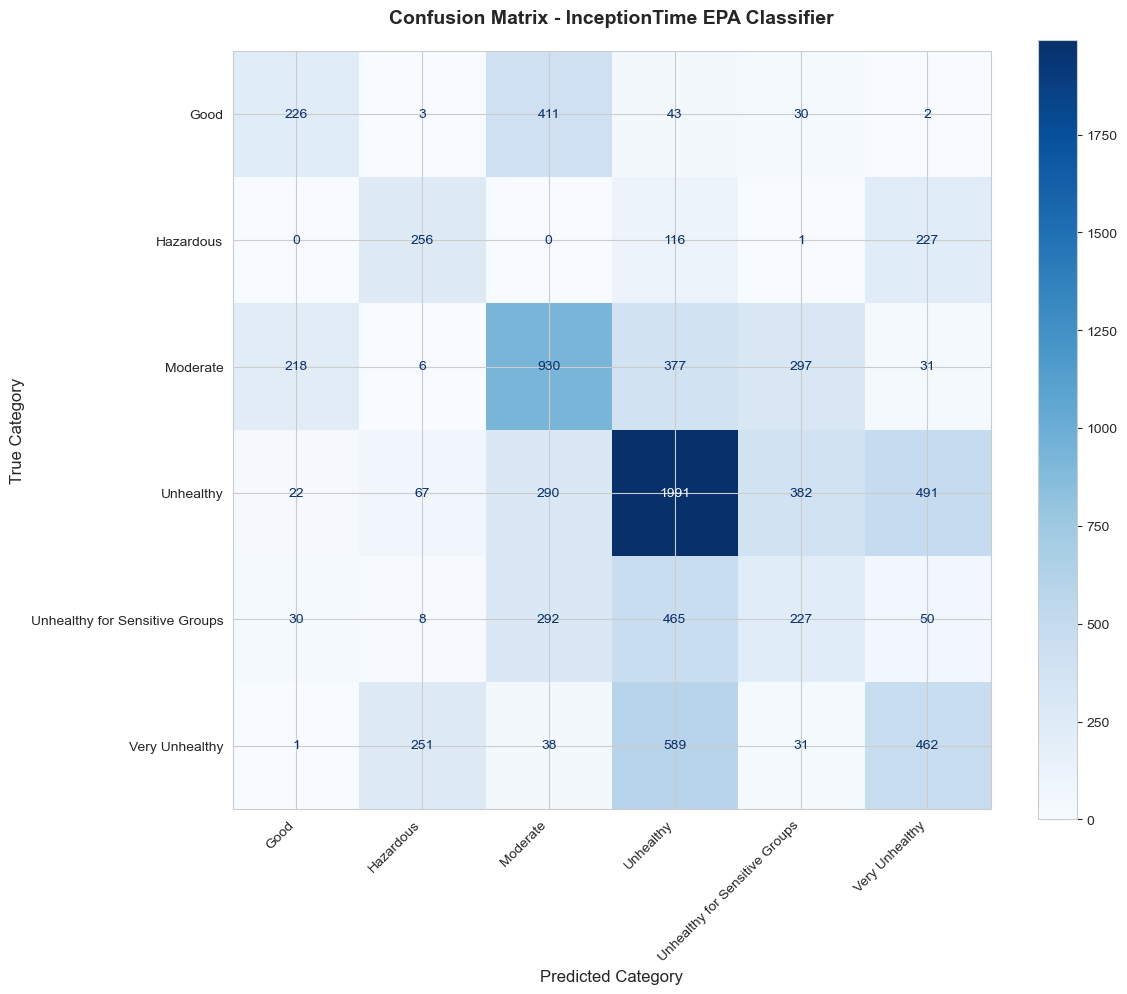

In [24]:
# Visualizzazioni

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 10))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d')

plt.title('Confusion Matrix - InceptionTime EPA Classifier', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Salva figura
fig_path = Path('../figures/classification')
fig_path.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path / 'confusion_matrix_inceptiontime.pdf', dpi=150, bbox_inches='tight')
print(f"✓ Confusion matrix salvata: {fig_path / 'confusion_matrix_inceptiontime.pdf'}")

plt.show()

✓ Training history salvata: ../figures/classification/inceptiontime_training_history.pdf


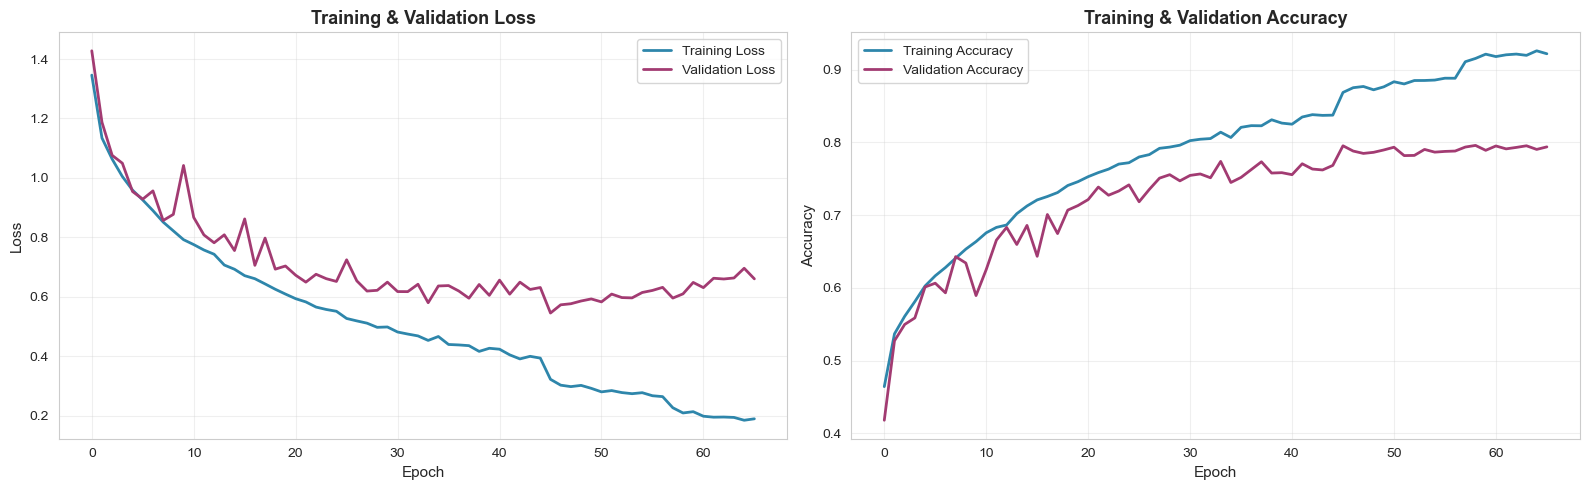


STATISTICHE TRAINING
   • Best Training Accuracy: 0.9259
   • Best Validation Accuracy: 0.7959
   • Final Training Loss: 0.1891
   • Final Validation Loss: 0.6602
   • Total Epochs: 66


In [25]:
# Training History

if inception_history_path.exists():
    with open(inception_history_path, 'rb') as f:
        history_dict = pickle.load(f)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Loss
    axes[0].plot(history_dict['train_loss'], label='Training Loss', linewidth=2, color='#2E86AB')
    axes[0].plot(history_dict['val_loss'], label='Validation Loss', linewidth=2, color='#A23B72')
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history_dict['train_acc'], label='Training Accuracy', linewidth=2, color='#2E86AB')
    axes[1].plot(history_dict['val_acc'], label='Validation Accuracy', linewidth=2, color='#A23B72')
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Accuracy', fontsize=11)
    axes[1].set_title('Training & Validation Accuracy', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(fig_path / 'inceptiontime_training_history.pdf', dpi=150, bbox_inches='tight')
    print(f"✓ Training history salvata: {fig_path / 'inceptiontime_training_history.pdf'}")
    plt.show()
    
    # Statistiche finali
    print("\n" + "="*70)
    print("STATISTICHE TRAINING")
    print("="*70)
    print(f"   • Best Training Accuracy: {max(history_dict['train_acc']):.4f}")
    print(f"   • Best Validation Accuracy: {max(history_dict['val_acc']):.4f}")
    print(f"   • Final Training Loss: {history_dict['train_loss'][-1]:.4f}")
    print(f"   • Final Validation Loss: {history_dict['val_loss'][-1]:.4f}")
    print(f"   • Total Epochs: {len(history_dict['train_loss'])}")
    print("="*70)
else:
    print("Training history non disponibile (modello caricato da file esistente)")

## Hyperparameter Optimization (Optuna)

Ottimizzazione veloce con griglia ridotta:
- **20 trials** totali (veloce!)
- **30 epochs** max per trial (con early stopping)
- Spazio di ricerca limitato ai parametri più importanti

In [26]:
# Installa Optuna se necessario
try:
    import optuna
    from optuna.pruners import MedianPruner
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna", "-q"])
    import optuna
    from optuna.pruners import MedianPruner

print(f"Optuna version: {optuna.__version__}")

Optuna version: 4.6.0


In [27]:
# Configura paths per ottimizzazione
optuna_db_path = models_dir / 'optuna_inceptiontime.db'
optuna_results_path = models_dir / 'optuna_best_params.pkl'

print(f"Optuna DB: {optuna_db_path}")
print(f"Best params: {optuna_results_path}")

Optuna DB: ../models/optuna_inceptiontime.db
Best params: ../models/optuna_best_params.pkl


In [28]:
def optuna_objective(trial):
    """
    Objective function per Optuna - GRIGLIA RIDOTTA per velocità
    """
    # Spazio di ricerca LIMITATO
    params = {
        'n_blocks': trial.suggest_int('n_blocks', 2, 3),           # Solo 2-3 blocks
        'depth': trial.suggest_int('depth', 4, 6),                 # 4-6 modules
        'n_filters': trial.suggest_categorical('n_filters', [32]), # FISSO a 32
        'bottleneck_size': trial.suggest_categorical('bottleneck_size', [32]), # FISSO
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-3, 5e-4]), # Solo 2 LR
        'batch_size': trial.suggest_categorical('batch_size', [64]), # FISSO
        'kernel_sizes': [10, 20, 40]  # FISSO
    }
    
    # Split validation (stesso di prima)
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_inception, y_train,
        test_size=0.2,
        random_state=42,
        stratify=y_train
    )
    
    train_dataset = TensorDataset(torch.FloatTensor(X_tr), torch.LongTensor(y_tr))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    
    # Crea modello
    model = InceptionTime(
        in_channels=X_train_inception.shape[1],
        n_classes=len(label_encoder.classes_),
        n_blocks=params['n_blocks'],
        n_filters=params['n_filters'],
        depth=params['depth'],
        bottleneck_size=params['bottleneck_size'],
        kernel_sizes=params['kernel_sizes']
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    # Training veloce: max 30 epochs, early stopping patience=5
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(30):  # MAX 30 epochs per trial
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        # Report per pruning
        trial.report(val_acc, epoch)
        
        # Pruning: ferma trial se non promettenti
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        # Early stopping veloce
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 5:  # Patience ridotta a 5
                break
    
    return best_val_acc  # Ottimizza accuracy validation


In [29]:
# Ottimizzazione Optuna - VELOCE (20 trials)

if optuna_results_path.exists():
    print("="*70)
    print("✓ RISULTATI OPTUNA ESISTENTI - CARICAMENTO")
    print("="*70)
    
    with open(optuna_results_path, 'rb') as f:
        best_params = pickle.load(f)
    
    print("\nBest hyperparameters trovati:")
    for key, value in best_params.items():
        print(f"   • {key}: {value}")
    print("="*70)
    
else:
    print("="*70)
    print("INIZIO OTTIMIZZAZIONE OPTUNA")
    print("="*70)
    print(f"   • Trials: 20")
    print(f"   • Max epochs per trial: 30")
    print(f"   • Early stopping: patience=5")
    print(f"   • Metrica: Validation Accuracy")
    print("="*70 + "\n")
    
    # Crea study con MedianPruner per fermare trial non promettenti
    study = optuna.create_study(
        study_name='inceptiontime_epa',
        storage=f'sqlite:///{optuna_db_path}',
        direction='maximize',  # Massimizza validation accuracy
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
        load_if_exists=True
    )
    
    # Esegui ottimizzazione - SOLO 20 TRIALS
    study.optimize(
        optuna_objective,
        n_trials=20,
        timeout=None,
        show_progress_bar=True
    )
    
    print("\n" + "="*70)
    print("OTTIMIZZAZIONE COMPLETATA")
    print("="*70)
    
    # Risultati
    best_trial = study.best_trial
    best_params = best_trial.params
    best_params['kernel_sizes'] = [10, 20, 40]  # Aggiungi param fisso
    
    print(f"\nBest validation accuracy: {best_trial.value:.4f}")
    print("\nBest hyperparameters:")
    for key, value in best_params.items():
        print(f"   • {key}: {value}")
    
    # Salva risultati
    with open(optuna_results_path, 'wb') as f:
        pickle.dump(best_params, f)
    
    print(f"\n✓ Best params salvati: {optuna_results_path.name}")
    print("="*70)
    
    # Visualizza importanza parametri
    try:
        fig = optuna.visualization.plot_param_importances(study)
        fig.show()
    except:
        print("\n(Visualizzazione importanza parametri non disponibile)")
    
    # Visualizza optimization history
    try:
        fig = optuna.visualization.plot_optimization_history(study)
        fig.show()
    except:
        print("(Visualizzazione history non disponibile)")

INIZIO OTTIMIZZAZIONE OPTUNA
   • Trials: 20
   • Max epochs per trial: 30
   • Early stopping: patience=5
   • Metrica: Validation Accuracy



[I 2025-12-10 23:35:06,787] A new study created in RDB with name: inceptiontime_epa
Best trial: 0. Best value: 0.757621:   5%|▌         | 1/20 [2:36:32<49:34:10, 9392.12s/it]

[I 2025-12-11 02:11:38,934] Trial 0 finished with value: 0.7576211894052973 and parameters: {'n_blocks': 3, 'depth': 5, 'n_filters': 32, 'bottleneck_size': 32, 'learning_rate': 0.001, 'batch_size': 64}. Best is trial 0 with value: 0.7576211894052973.


Best trial: 0. Best value: 0.757621:  10%|█         | 2/20 [4:23:53<38:16:57, 7656.55s/it]

[I 2025-12-11 03:59:00,580] Trial 1 finished with value: 0.7503748125937032 and parameters: {'n_blocks': 2, 'depth': 5, 'n_filters': 32, 'bottleneck_size': 32, 'learning_rate': 0.001, 'batch_size': 64}. Best is trial 0 with value: 0.7576211894052973.


Best trial: 2. Best value: 0.75912:  15%|█▌        | 3/20 [6:32:36<36:17:58, 7686.96s/it] 

[I 2025-12-11 06:07:43,738] Trial 2 finished with value: 0.7591204397801099 and parameters: {'n_blocks': 3, 'depth': 4, 'n_filters': 32, 'bottleneck_size': 32, 'learning_rate': 0.001, 'batch_size': 64}. Best is trial 2 with value: 0.7591204397801099.


Best trial: 2. Best value: 0.75912:  20%|██        | 4/20 [7:58:53<29:45:35, 6695.98s/it]

[I 2025-12-11 07:34:00,531] Trial 3 finished with value: 0.755872063968016 and parameters: {'n_blocks': 2, 'depth': 4, 'n_filters': 32, 'bottleneck_size': 32, 'learning_rate': 0.0005, 'batch_size': 64}. Best is trial 2 with value: 0.7591204397801099.


Best trial: 4. Best value: 0.763618:  25%|██▌       | 5/20 [9:26:14<25:42:48, 6171.26s/it]

[I 2025-12-11 09:01:21,411] Trial 4 finished with value: 0.7636181909045477 and parameters: {'n_blocks': 2, 'depth': 4, 'n_filters': 32, 'bottleneck_size': 32, 'learning_rate': 0.0005, 'batch_size': 64}. Best is trial 4 with value: 0.7636181909045477.


Best trial: 4. Best value: 0.763618:  30%|███       | 6/20 [11:24:26<25:13:01, 6484.42s/it]

[I 2025-12-11 10:59:33,737] Trial 5 finished with value: 0.7541229385307346 and parameters: {'n_blocks': 2, 'depth': 5, 'n_filters': 32, 'bottleneck_size': 32, 'learning_rate': 0.0005, 'batch_size': 64}. Best is trial 4 with value: 0.7636181909045477.


Best trial: 4. Best value: 0.763618:  35%|███▌      | 7/20 [12:12:57<19:11:50, 5316.18s/it]

[I 2025-12-11 11:48:04,709] Trial 6 pruned. 


Best trial: 4. Best value: 0.763618:  35%|███▌      | 7/20 [12:59:28<24:07:36, 6681.28s/it]



[W 2025-12-11 12:34:35,779] Trial 7 failed with parameters: {'n_blocks': 3, 'depth': 6, 'n_filters': 32, 'bottleneck_size': 32, 'learning_rate': 0.0005, 'batch_size': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/zenith378/miniconda3/envs/zfit-env/lib/python3.12/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/c7/8sr01rtn1bjb9h_rzy93bvsm0000gn/T/ipykernel_7891/1280083679.py", line 50, in optuna_objective
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/c7/8sr01rtn1bjb9h_rzy93bvsm0000gn/T/ipykernel_7891/607502155.py", line 38, in evaluate
    outputs = model(X_batch)
              ^^^^^^^^^^^^^^
  File "/Users/zenith378/miniconda3/envs/zfit-env/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1775

KeyboardInterrupt: 

## Training Finale con Best Hyperparameters

Training completo del modello con i parametri ottimali trovati da Optuna.

In [ ]:
# Training finale con best params

# Verifica se esiste già modello finale ottimizzato
final_model_path = models_dir / 'inceptiontime_final_optimized.pth'
final_config_path = models_dir / 'inceptiontime_final_config.pkl'
final_history_path = models_dir / 'inceptiontime_final_history.pkl'

if final_model_path.exists():
    print("="*70)
    print("✓ MODELLO FINALE OTTIMIZZATO GIÀ ESISTENTE - CARICAMENTO")
    print("="*70)
    
    # Carica config
    with open(final_config_path, 'rb') as f:
        final_config = pickle.load(f)
    
    # Ricostruisci modello
    best_model = InceptionTime(
        in_channels=X_train_inception.shape[1],
        n_classes=len(label_encoder.classes_),
        n_blocks=2#final_config['n_blocks'],
        n_filters=32#final_config['n_filters'],
        depth=final_config['depth'],
        bottleneck_size=final_config['bottleneck_size'],
        kernel_sizes=final_config['kernel_sizes']
    ).to(device)
    
    best_model.load_state_dict(torch.load(final_model_path, map_location=device))
    best_model.eval()
    
    print(f"Modello caricato da: {final_model_path.name}")
    print("="*70)
    
else:
    print("="*70)
    print("TRAINING FINALE CON BEST HYPERPARAMETERS")
    print("="*70)
    
    # Split validation
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_inception, y_train,
        test_size=0.2,
        random_state=42,
        stratify=y_train
    )
    
    print(f"\nDimensioni dataset:")
    print(f"   Training:   {len(X_tr):,} samples")
    print(f"   Validation: {len(X_val):,} samples")
    print(f"   Test:       {len(X_test_inception):,} samples")
    
    train_dataset = TensorDataset(torch.FloatTensor(X_tr), torch.LongTensor(y_tr))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
    
    # Crea modello con best params
    best_model = InceptionTime(
        in_channels=X_train_inception.shape[1],
        n_classes=len(label_encoder.classes_),
        n_blocks=best_params['n_blocks'],
        n_filters=best_params['n_filters'],
        depth=best_params['depth'],
        bottleneck_size=best_params['bottleneck_size'],
        kernel_sizes=best_params['kernel_sizes']
    ).to(device)
    
    print(f"\nModello InceptionTime (optimized):")
    print(f"   Parametri totali: {sum(p.numel() for p in best_model.parameters()):,}")
    for key, value in best_params.items():
        print(f"   • {key}: {value}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, verbose=False
    )
    
    # Training loop completo (150 epochs max, patience=20)
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print("\n" + "="*70)
    print("INIZIO TRAINING FINALE")
    print("="*70)
    
    for epoch in range(150):
        train_loss, train_acc = train_epoch(best_model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(best_model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_loss)
        
        # Early stopping e checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(best_model.state_dict(), final_model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⏹ Early stopping at epoch {epoch+1}")
                break
        
        # Progress ogni 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                  f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    
    # Carica best weights
    best_model.load_state_dict(torch.load(final_model_path, map_location=device))
    
    print("\n" + "="*70)
    print("SALVATAGGIO FILES")
    print("="*70)
    
    # Salva config e history
    with open(final_config_path, 'wb') as f:
        pickle.dump(best_params, f)
    print(f"✓ Config salvata: {final_config_path.name}")
    
    with open(final_history_path, 'wb') as f:
        pickle.dump(history, f)
    print(f"✓ History salvata: {final_history_path.name}")
    
    print(f"✓ Modello salvato: {final_model_path.name}")
    print("="*70)

## Valutazione Modello Ottimizzato

In [ ]:
# Valutazione sul Test Set (modello ottimizzato)

print("="*70)
print("VALUTAZIONE SUL TEST SET - MODELLO OTTIMIZZATO")
print("="*70)

best_model.eval()

# Crea test DataLoader
test_dataset = TensorDataset(torch.FloatTensor(X_test_inception), torch.LongTensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = evaluate(best_model, test_loader, criterion, device)

print(f"\nMetriche Test Set:")
print(f"   • Test Loss: {test_loss:.4f}")
print(f"   • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Predizioni complete
all_preds = []
all_probs = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = best_model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_pred = np.array(all_preds)
y_probs = np.array(all_probs)

# Classification Report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(
    y_test, 
    y_pred, 
    target_names=label_encoder.classes_,
    digits=4
))
print("="*70)

In [ ]:
# Confusion Matrix (modello ottimizzato)

fig, ax = plt.subplots(figsize=(12, 10))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d')

plt.title('Confusion Matrix - InceptionTime Optimized', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Salva figura
fig_path = Path('../figures/classification')
fig_path.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path / 'confusion_matrix_inceptiontime_optimized.pdf', dpi=150, bbox_inches='tight')
print(f"✓ Confusion matrix salvata: {fig_path / 'confusion_matrix_inceptiontime_optimized.pdf'}")

plt.show()

In [ ]:
# Training History (modello ottimizzato)

if final_history_path.exists():
    with open(final_history_path, 'rb') as f:
        history_dict = pickle.load(f)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Loss
    axes[0].plot(history_dict['train_loss'], label='Training Loss', linewidth=2, color='#2E86AB')
    axes[0].plot(history_dict['val_loss'], label='Validation Loss', linewidth=2, color='#A23B72')
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].set_title('Training & Validation Loss (Optimized)', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history_dict['train_acc'], label='Training Accuracy', linewidth=2, color='#2E86AB')
    axes[1].plot(history_dict['val_acc'], label='Validation Accuracy', linewidth=2, color='#A23B72')
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Accuracy', fontsize=11)
    axes[1].set_title('Training & Validation Accuracy (Optimized)', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(fig_path / 'inceptiontime_optimized_training_history.pdf', dpi=150, bbox_inches='tight')
    print(f"✓ Training history salvata: {fig_path / 'inceptiontime_optimized_training_history.pdf'}")
    plt.show()
    
    # Statistiche finali
    print("\n" + "="*70)
    print("STATISTICHE TRAINING - MODELLO OTTIMIZZATO")
    print("="*70)
    print(f"   • Best Training Accuracy: {max(history_dict['train_acc']):.4f}")
    print(f"   • Best Validation Accuracy: {max(history_dict['val_acc']):.4f}")
    print(f"   • Final Training Loss: {history_dict['train_loss'][-1]:.4f}")
    print(f"   • Final Validation Loss: {history_dict['val_loss'][-1]:.4f}")
    print(f"   • Total Epochs: {len(history_dict['train_loss'])}")
    print(f"   • Test Accuracy: {test_accuracy:.4f}")
    print("="*70)
else:
    print("Training history non disponibile")